In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

import hls4ml
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute
from hls4ml.model.types import FixedPrecisionType, RoundingMode, SaturationMode

# Source the Vivado path
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

np.random.seed(0)
tf.random.set_seed(0)

# Locals
from crop_utils import create_training_data, plot_borders_norm

2024-10-10 16:07:05.933677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 16:07:06.198805: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 16:07:06.212409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-10 16:07:06.212457: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

/home/aelabd/RHEED/hls4ml/hls4ml/converters/__init__.py:29: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


# Sample/testing data

images.shape = (num_samples, image_size[1], image_size[0], 1) =  (2, 48, 128, 1)
crop_coords.shape = (num_samples, num_blobs, 4) =  (2, 5, 4)


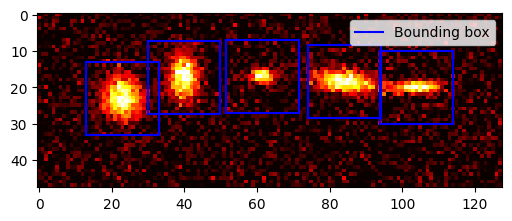

In [5]:
num_samples = 2  # Number of training samples
images, gauss_params, crop_coords = create_training_data(num_samples, noise_std=0.05)

print("images.shape = (num_samples, image_size[1], image_size[0], 1) = ", images.shape)
print("crop_coords.shape = (num_samples, num_blobs, 4) = ", crop_coords.shape)
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.imshow(images[0].squeeze(), cmap='hot', vmin=0, vmax=1)
plot_borders_norm(ax, crop_coords[0])
plt.show(fig)

# 1. Define CropLayer and Model

In [8]:
class CropLayer(layers.Layer):
    def __init__(self, image_shape, crop_shape, num_boxes, **kwargs):
        super(CropLayer, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.crop_shape = crop_shape
        self.num_boxes = num_boxes

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * self.num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=self.num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, self.crop_shape
        )
        
        return cropped_images
    
    def get_config(self):
        # Breaks serialization and parsing in hls4ml if not defined
        return super().get_config()

    
def build_crop_model(image_shape, crop_size, num_boxes):
    inputs = layers.Input(shape=image_shape)
    crop_boxes = layers.Input(shape=(num_boxes, 4))
    x = CropLayer(image_shape, crop_size, num_boxes)([inputs, crop_boxes])
    model = Model(inputs=[inputs, crop_boxes], outputs=x)
    return model

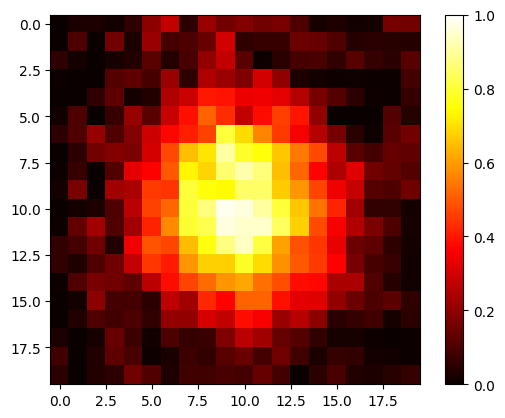

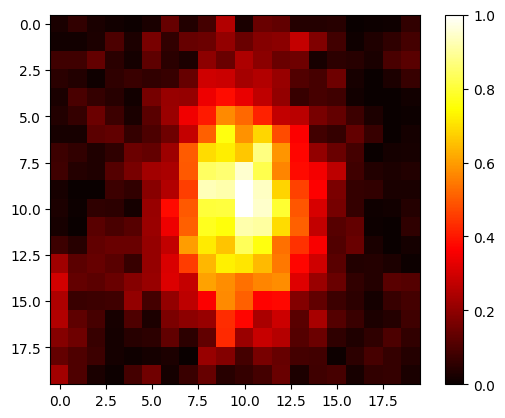

In [9]:
model = build_crop_model((48, 128, 1), (20,20), 5)

cropped_images = model([images, crop_coords]).numpy().squeeze()
for i in range(2):
    plt.figure()
    plt.imshow(cropped_images[i], cmap='hot', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    plt.close()

# 2. Convert into hls4ml object

In [10]:
def parse_crop_layer(keras_layer, input_names, input_shapes, data_reader):
    assert 'CropLayer' in keras_layer['class_name']
    layer = parse_default_keras_layer(keras_layer, input_names)

    img_shape = input_shapes[0]
    crop_boxes_shape = input_shapes[1]

    print(f"input_shapes: {input_shapes}")
    num_boxes = crop_boxes_shape[1]
    num_channels = img_shape[-1]
    crop_shape = (20, 20) # TODO: Ditch hardcode # crop_shape = keras_layer['config']['crop_shape']
    output_shape = [None, num_boxes, crop_shape[0], crop_shape[1], num_channels]

    return layer, output_shape

hls4ml.converters.register_keras_layer_handler('CropLayer', parse_crop_layer)

In [11]:
class HCropLayer(hls4ml.model.layers.Layer):
    "hls4ml implementation of the CropLayer"

    def initialize(self):
        inp_0 = self.model.get_layer_output_variable(self.inputs[0]) # Image
        inp_1 = self.model.get_layer_output_variable(self.inputs[1]) # Crop-box coordinates

        num_channels = inp_0.shape[-1]
        num_channels_name = inp_0.dim_names[-1]
        num_boxes = inp_1.shape[0]
        num_boxes_name = inp_1.dim_names[0]
        crop_shape = (20,20) # TODO: Ditch hardcode # self.get_attr('crop_shape')
        shape = [num_boxes, crop_shape[0], crop_shape[1], num_channels]
        dim_names = [num_boxes_name, f"CROP_ROWS_{self.index}", f"CROP_COLS_{self.index}", num_channels_name]
        self.add_output_variable(shape, dim_names)

hls4ml.model.layers.register_layer('CropLayer', HCropLayer)

In [12]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend="Vivado")
print(f"config: {config}")
hmodel = hls4ml.converters.convert_from_keras_model(
        model,
        output_dir=str(f'hls4mlprj_CropLayer'),
        backend="Vivado",
        io_type='io_parallel',
        hls_config=config #{'Model': {'Precision': 'ap_int<6>', 'ReuseFactor': 1}},
    )

Interpreting Model
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 5, 4]], output shape: [None, 5, 4]
input_shapes: [[None, 48, 128, 1], [None, 5, 4]]
Layer name: crop_layer_1, layer type: CropLayer, input shapes: [[None, 48, 128, 1], [None, 5, 4]], output shape: [None, 5, 20, 20, 1]
config: {'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'BramFactor': 1000000000, 'TraceOutput': False}}
Interpreting Model
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 5, 4]], output shape: [None, 5, 4]
input_shapes: [[None, 48, 128, 1], [None, 5, 4]]
Layer name: crop_layer_1, layer type: CropLayer, input shapes: [[None, 48, 128, 1], [None, 5, 4]], output shape: [None, 5, 20, 2